#### Stacking Ensemble References - 

https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28#:~:text=Stacking%20is%20a%20strong%20ensemble,stacked%20ensembles%20or%20stacked%20generalization.

https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/

https://www.javatpoint.com/stacking-in-machine-learning

https://www.analyticsvidhya.com/blog/2021/08/ensemble-stacking-for-machine-learning-and-deep-learning/

#### Use this Figure - 
https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28#:~:text=Stacking%20is%20a%20strong%20ensemble,stacked%20ensembles%20or%20stacked%20generalization.

# Import Libraries

In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

# Load data Training and Testing Data

In [2]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

# Loading individual models

In [3]:
ann_model = load_model('EEG_Driver_Drowsiness_ANN_Architecture.h5')
lstm_model = load_model('EEG_Driver_Drowsiness_LSTM_Architecture.h5')
gru_model = load_model('EEG_Driver_Drowsiness_GRU_Architecture.h5')

In [4]:
# Get predictions from base models on training data
ann_pred = ann_model.predict(X_train)
lstm_pred = lstm_model.predict(X_train)
gru_pred = gru_model.predict(X_train)

19412/19412 [==============================] - 83s 4ms/step


In [5]:
# Stack predictions horizontally for meta-model training data
X_train_stacked = np.hstack((ann_pred, lstm_pred, gru_pred))

In [6]:
X_train_stacked.shape

(621158, 3)

In [7]:
# Train meta-model (Random Forest classifier)
meta_model = RandomForestClassifier(n_estimators=100, random_state=42)
meta_model.fit(X_train_stacked, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Get predictions from base models on test data
ann_pred_test = ann_model.predict(X_test)
lstm_pred_test = lstm_model.predict(X_test)
gru_pred_test = gru_model.predict(X_test)

4853/4853 [==============================] - 59s 12ms/step


In [9]:
# Stack predictions horizontally for meta-model test data
X_test_stacked = np.hstack((ann_pred_test, lstm_pred_test, gru_pred_test))

In [10]:
X_test_stacked.shape

(155290, 3)

# Model Evaluation

## Importing Libraries - Evaluation

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Predict using meta-model

In [12]:
ensemble_pred_test = meta_model.predict(X_test_stacked)

## Classification Report

In [13]:
classification_report = classification_report(y_test, ensemble_pred_test)
print(classification_report)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     77676
           1       0.91      0.89      0.90     77614

    accuracy                           0.90    155290
   macro avg       0.90      0.90      0.90    155290
weighted avg       0.90      0.90      0.90    155290



## Confusion Matrix

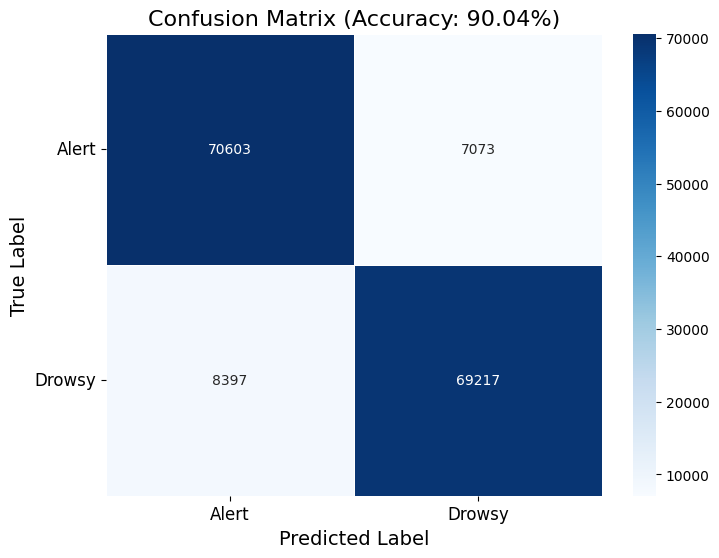

In [14]:
class_labels = ["Alert", "Drowsy"]

conf_matrix = confusion_matrix(y_test, ensemble_pred_test)
accuracy = accuracy_score(y_test, ensemble_pred_test) * 100

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels, linewidths=.5)

plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f}%)', fontsize=16)

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

plt.xticks(rotation=0, fontsize=12)  
plt.yticks(rotation=0, fontsize=12)  

plt.show()

## Evaluation Metrics

In [15]:
# Calculate accuracy, precision, recall, F1-score, AUC-ROC

accuracy = accuracy_score(y_test, ensemble_pred_test)
precision = precision_score(y_test, ensemble_pred_test)
recall = recall_score(y_test, ensemble_pred_test)
f1 = f1_score(y_test, ensemble_pred_test)
auc_roc = roc_auc_score(y_test, ensemble_pred_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)

Accuracy: 0.9003799343164403
Precision: 0.9072879800760257
Recall: 0.891810755791481
F1-score: 0.8994827944692796
AUC-ROC: 0.900376514411524


## Receiver Operating Characteristic (ROC) Curve

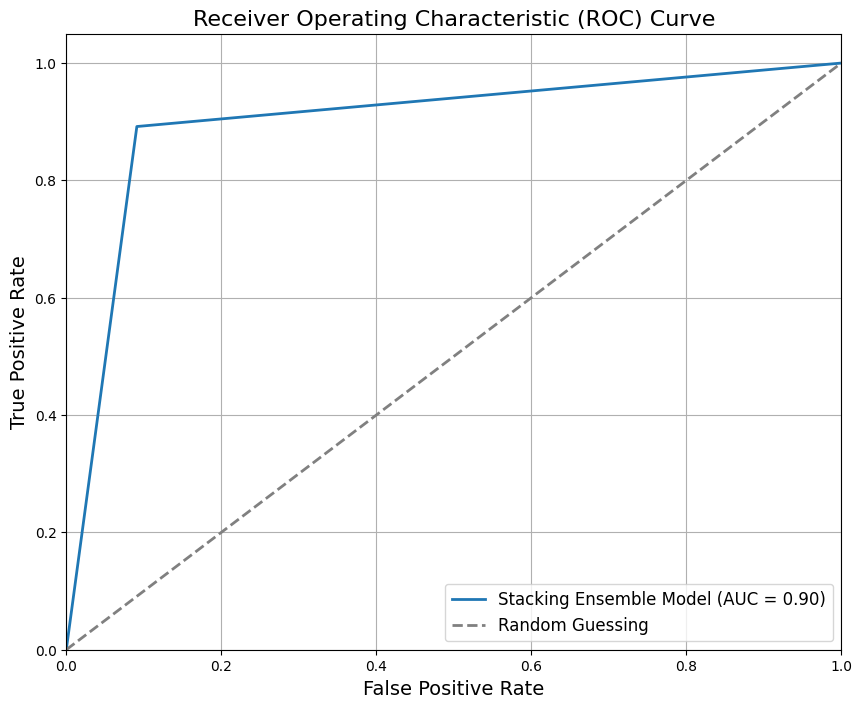

In [16]:
roc_data = {}

fpr, tpr, thresholds = roc_curve(y_test, ensemble_pred_test)
roc_auc = auc(fpr, tpr)
roc_data['Stacking Ensemble Model'] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

# Plotting ROC Curves 
plt.figure(figsize=(10, 8))
for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], lw=2, label=f'{name} (AUC = {data["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()